In [1]:

# Importación de librerías necesarias para el procesamiento de datos y análisis
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lime
import lime.lime_tabular
from sklearn.calibration import CalibratedClassifierCV
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sklearn
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.calibration import LabelEncoder
import seaborn as sns
from sklearn.metrics import roc_curve, auc,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

In [2]:
## CARGA DE MODELOS

def cargar_datos():
    # Verificar si los archivos con los datos ya existen
    
    if os.path.exists('datos_X_DDOS.csv') and os.path.exists('datos_Y_DDOS.csv'):
        X = pd.read_csv('datos_X_DDOS.csv')
       # y = pd.read_csv('datos_y.csv', header=None, squeeze=True)  # Usar squeeze=True para obtener una Serie
        y = pd.read_csv('datos_Y_DDOS.csv', header=None, skiprows=1).iloc[:, 0]  # Obtener la Serie de una sola columna
    else:
        # Recopilación de archivos CSV de un directorio y concatenación en un DataFrame
        csv_files = []
        for dirname, _, filenames in os.walk('dataset\MachineLearningCSV_reducido\MachineLearningCVE'):
            for filename in filenames:
                csv_file = os.path.join(dirname, filename)
                print(os.path.join(dirname, filename))
                csv_files.append(csv_file)
        df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

        # Limpieza de datos: eliminación de espacios en nombres de columnas y valores nulos o infinitos
        df.columns = df.columns.str.strip()
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # Preprocesamiento de la columna 'Label' para agrupar categorías de ataques similares
        df_experiment = df.copy(deep=True)
        df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
        df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
        df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DDoS", inplace=True)

        # División de los datos en conjuntos de entrenamiento y prueba
        y = df_experiment.Label
        X = df_experiment.drop(columns='Label')

        # Guardar los datos en archivos CSV
        X.to_csv('datos_X_DDOS.csv', index=False)
        y.to_csv('datos_Y_DDOS.csv', index=False)

    return X, y

# Definir una función para realizar validación cruzada y obtener métricas de rendimiento
def cross_validate_model(model, X, y,model_name,cv=5):
    try: 
        scores = joblib.load(f'{model_name}_cross_val_results.pkl')      
    except FileNotFoundError:
        scores = cross_val_score(model, X, y, cv=cv)
        joblib.dump(scores,f'{model_name}_cross_val_results.pkl')

    print("Puntuaciones de validación cruzada:", scores)
    print("Media de puntuaciones:", scores.mean())
    print("Desviación estándar de puntuaciones:", scores.std())

def evaluate_model(model, X_test, y_test, X_selected, y, model_name):
    # Realizar predicciones y calcular la puntuación del modelo
    try: 
        score = joblib.load(f'{model_name}_score.pkl')
    except FileNotFoundError:
        score = model.score(X_test, y_test)
        joblib.dump(score,f'{model_name}_score.pkl')

    print(f"Puntuación del {model_name}: {score}") 
    print(f"Validación cruzada para {model_name}:")
    cross_validate_model(model, X_selected, y, model_name)
    mostrar_ejemplos_predicciones(model, model_name, X_test, y_test)
   
def test_svm_models(X_train, X_test, y_train, y_test, kernel, degree=0):

    if kernel == 'poly':
        svm_model = SVC(kernel=kernel, degree=degree)
        svm_model.fit(X_train, y_train)
        joblib.dump(svm_model, f'svm_model_{kernel}_degree_{degree}DDOS.pkl')
        score = svm_model.score(X_test, y_test)
        print(f"Score del SVM con kernel {kernel}: {score:.4f}: ")
    else:
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_train, y_train)
        joblib.dump(svm_model, f'svm_model_{kernel}DDOS.pkl')
        score = svm_model.score(X_test, y_test)
        print(f"Score del SVM con kernel {kernel}: {score:.4f}: ")

# Función para mostrar ejemplos de predicciones
def mostrar_ejemplos_predicciones(modelo, modelo_name,X_test, y_test, num_ejemplos=5):
    predicciones = modelo.predict(X_test)
    print("\nMatriz de confusión del modelo: "+f'{modelo_name}')
    print(confusion_matrix(y_test, predicciones))
    print("\nInforme de clasificación del modelo: "+f'{modelo_name}')
    print(classification_report(y_test, predicciones))

    # print("Ejemplos de predicciones:")
    # for i in range(num_ejemplos):
    #     ejemplo_prediccion = f"Ejemplo {i+1}: Predicción={predicciones[i]}, Verdadero={y_test.iloc[i]}"
    #     print(ejemplo_prediccion)

# Función para graficar la curva ROC de todos los modelos
def plot_roc_curves(models, X_test, y_test, y_test_encoded):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test_encoded, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
## CARGA DE DATOS

# Si tienes problemas  de rendimiento en algún punto puedes cargar los modelos, valores SHAP, explicadores, calibradores etc 
# desde mi github (https://github.com/javierluquerueda/XAI-para-la-Deteccion-Confiable-de-Intrusiones-Explicabilidad-e-Interpretabilidad).

X,y = cargar_datos()

try: 
    X_scaled = joblib.load('X_scaled.pkl')
    top_20_feature_names = joblib.load('top_20_feature_names.pkl')
    indices = joblib.load('indices.pkl')
except FileNotFoundError:
    forest = RandomForestClassifier()
    forest.fit(X, y)
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    joblib.dump(indices,'indices.pkl')
    top_20_feature_indices = indices[:20]  # Índices de las 20 características más importantes
    top_20_feature_names = X.columns[top_20_feature_indices].tolist() # Nombres de las 20 características más importantes
    joblib.dump(top_20_feature_names,'top_20_feature_names.pkl')
    X_selected = X.values[:, indices[:20]]  # Seleccionar las 20 características más importantes
    # Normalizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    joblib.dump(X_scaled,'X_scaled.pkl')

try: 
    X_train = joblib.load('X_train.pkl')
    X_test = joblib.load('X_test.pkl')
    y_train = joblib.load('y_train.pkl')
    y_test = joblib.load('y_test.pkl')
    X_train_df = pd.DataFrame(X_train, columns=top_20_feature_names)
    X_test_df = pd.DataFrame(X_test, columns=top_20_feature_names)

except FileNotFoundError:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    joblib.dump(X_train,'X_train.pkl')
    joblib.dump(X_test,'X_test.pkl')
    joblib.dump(y_train,'y_train.pkl')
    joblib.dump(y_test,'y_test.pkl')

try:
    randomForest_modelDDOS = joblib.load('randomForest_model_DDOS.pkl')
except FileNotFoundError:
    randomForest_modelDDOS = RandomForestClassifier()
    randomForest_modelDDOS.fit(X_train, y_train)
    joblib.dump(randomForest_modelDDOS, 'randomForest_model_DDOS.pkl')

try:
    svm_model_linearDDOS = joblib.load('svm_model_linearDDOS.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "linear")

try:
    svm_model_poly_degree_2DDOS = joblib.load('svm_model_poly_degree_2DDOS.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "poly", 2)

try:
    svm_model_poly_degree_3DDOS = joblib.load('svm_model_poly_degree_3DDOS.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "poly", 3)

try:
    svm_model_rbfDDOS = joblib.load('svm_model_rbfDDOS.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "rbf")

try: 
    lgb_model_DDOS = joblib.load('lgb_model_DDOS.pkl')
    #evaluate_model(lgb_model_DDOS, X_test, y_test, X_scaled, y, "lgbModel")
except FileNotFoundError:
    lgb_model = lgb.LGBMClassifier(verbosity=-1)
    lgb_model.fit(X_train, y_train)
    joblib.dump(lgb_model, 'lgb_model_DDOS.pkl')

try: 
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    y_encoded = label_encoder.transform(y)
    y_test_encoded_series = pd.Series(y_test_encoded)
    xgBoost_model_DDOS = joblib.load('xgBoost_model_DDOS.pkl')
    #evaluate_model(xgBoost_model_DDOS, X_test, y_test_encoded_series, X_scaled, y_encoded, "xgBoost")
except FileNotFoundError:
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    xgBoost_model = xgb.XGBClassifier()
    xgBoost_model.fit(X_train, y_train_encoded)
    joblib.dump(xgBoost_model, 'xgBoost_model_DDOS.pkl')

try: 
    logisticRegression_model_DDOS = joblib.load('logisticRegression_model_DDOS.pkl')
    #evaluate_model(logisticRegression_model_DDOS, X_test, y_test, X_scaled, y, "logistic")
except FileNotFoundError:
    # Entrenamiento del modelo
    logistic_model = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)
    logistic_model.fit(X_train, y_train)
    joblib.dump(logistic_model, 'logisticRegression_model_DDOS.pkl')

try: 
    mlp_model_DDOS = joblib.load('mlp_model_DDOS.pkl')
    #evaluate_model(mlp_model_DDOS,X_test,y_test,X_scaled,y,"mlp_model")
except FileNotFoundError:
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
    mlp_model.fit(X_train,y_train)
    joblib.dump(mlp_model,'mlp_model_DDOS.pkl')


C:\Users\Javier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Javier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  w

In [4]:
# Carga de modelos calibrados
# Importante para los SVM hay que calibrarlos con CalibratedClassifierCV
# para habilitar la predicción de probabilidades (predict_proba), Aunque establecer probability=True permite 
# la estimación de probabilidades, puedes mejorar la calidad de estas probabilidades calibrando el modelo con 
# CalibratedClassifierCV.

try:
    calibrated_svmLineal = joblib.load('calibrated_svmLineal')
except FileNotFoundError:
    calibrated_svmLineal = CalibratedClassifierCV(svm_model_linearDDOS, method='sigmoid',cv='prefit')
    calibrated_svmLineal.fit(X_train, y_train)
    joblib.dump(calibrated_svmLineal, 'calibrated_svmLineal')

try:
    calibrated_svmPoly2 = joblib.load('calibrated_svmPoly2')
except FileNotFoundError:
    calibrated_svmPoly2 = CalibratedClassifierCV(svm_model_poly_degree_2DDOS, method='sigmoid',cv='prefit')
    calibrated_svmPoly2.fit(X_train, y_train)
    joblib.dump(calibrated_svmPoly2, 'calibrated_svmPoly2')

try:
    calibrated_svmPoly3 = joblib.load('calibrated_svmPoly3')
except FileNotFoundError:
    calibrated_svmPoly3 = CalibratedClassifierCV(svm_model_poly_degree_3DDOS, method='sigmoid',cv='prefit')
    calibrated_svmPoly3.fit(X_train, y_train)
    joblib.dump(calibrated_svmPoly3, 'calibrated_svmPoly3')

try:
    calibrated_svmRbf = joblib.load('calibrated_svmRbf')
except FileNotFoundError:
    calibrated_svmRbf = CalibratedClassifierCV(svm_model_rbfDDOS, method='sigmoid',cv='prefit')
    calibrated_svmRbf.fit(X_train, y_train)
    joblib.dump(calibrated_svmRbf, 'calibrated_svmRbf')


In [58]:
## EVALUACIONES DE ACCURACY Y VALIDACION CRUZADA
# print(top_20_feature_names)
# print("Etiquetas únicas y cantidad de clases:")
# labels = y.unique()
# classes = y.nunique()
# print("labels:", labels) 
# print("classes", classes)

# Evaluar cada modelo, precisión, puntuaciones de validación cruzada, su media y desviación estándar 

evaluate_model(randomForest_modelDDOS, X_test, y_test, X_scaled, y, "randomForest_model_DDOS")
print("\n")
evaluate_model(logisticRegression_model_DDOS, X_test, y_test, X_scaled, y, "logistic")
print("\n")
evaluate_model(mlp_model_DDOS, X_test, y_test, X_scaled, y, "mlp_model")
print("\n")
evaluate_model(lgb_model_DDOS, X_test, y_test, X_scaled, y, "lgbModel")
print("\n")
evaluate_model(xgBoost_model_DDOS, X_test, y_test_encoded_series, X_scaled, y_encoded, "xgBoost")
print("\n")
evaluate_model(svm_model_linearDDOS, X_test, y_test, X_scaled, y, "svm_model_linearDDOS")
print("\n")
evaluate_model(svm_model_poly_degree_2DDOS, X_test, y_test, X_scaled, y, "svm_model_poly_degree_2DDOS")
print("\n")
evaluate_model(svm_model_poly_degree_3DDOS, X_test, y_test, X_scaled, y, "svm_model_poly_degree_3DDOS")
print("\n")
evaluate_model(svm_model_rbfDDOS, X_test, y_test, X_scaled, y, "svm_model_rbfDDOS") 


models = {
    'Random Forest': randomForest_modelDDOS,
    'Logistic Regression': logisticRegression_model_DDOS,
    'MLP': mlp_model_DDOS,
    'LightGBM': lgb_model_DDOS,
    'XGBoost': xgBoost_model_DDOS,
    'SVM Linear': svm_model_linearDDOS,
    'SVM Poly Degree 2': svm_model_poly_degree_2DDOS,
    'SVM Poly Degree 3': svm_model_poly_degree_3DDOS,
    'SVM RBF': svm_model_rbfDDOS
}

# Descomentar para mostrar la curva ROC de todos los modelos, tarda 10 min aprox
# plot_roc_curves(models, X_test, y_test, y_test_encoded)

Puntuación del randomForest_model_DDOS: 0.9998006335422989
Validación cruzada para randomForest_model_DDOS:
Puntuaciones de validación cruzada: [0.99869304 0.99988924 0.99977848 0.99968987 0.99743033]
Media de puntuaciones: 0.9990961911610381
Desviación estándar de puntuaciones: 0.0009364303114702419

Matriz de confusión del modelo: randomForest_model_DDOS
[[19537     1]
 [    8 25597]]

Informe de clasificación del modelo: randomForest_model_DDOS
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19538
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



Puntuación del logistic: 0.9856677668741555
Validación cruzada para logistic:
Puntuaciones de validación cruzada: [0.95199699 0.97760401 0.98591112 0.97069248 0.9522396 ]
Media de puntuaciones: 0.96768883967486
Desviaci

In [5]:
## EXPLICABILIDAD GLOBAL
#IMPORTANCIA DE CARACTERÍSTICAS CON COEFICIENTES DEL MODELO

# Obtener los coeficientes del modelo SVM lineal o Logistic Regression, solo funciona con los modelos que se 
# pueden ajustar linealmente, para ello llamar a la función (en la última celda) con el modelo y los nombres 
# de las 20 características. Ejemplos de como se llamaría con cada uno de los modelos:

# explicabilidad_global(logisticRegression_model_DDOS, top_20_feature_names)
# explicabilidad_global(svm_model_linearDDOS, top_20_feature_names)

# Function to display global feature importance
def explicabilidad_global(model, feature_names):
    try:
        coeficientes = model.coef_[0]
        importancias = np.abs(coeficientes)
    except AttributeError:
        print("Este modelo no proporciona coeficientes directamente.")
        return
    
    scaler = MinMaxScaler()
    importancias_normalizadas = scaler.fit_transform(importancias.reshape(-1, 1)).flatten()
    
    plt.bar(range(len(importancias_normalizadas)), importancias_normalizadas)
    plt.xticks(range(len(importancias_normalizadas)), feature_names, rotation='vertical')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.title('Importancia de características del modelo')
    plt.tight_layout()
    plt.show()

In [18]:
## VALORES DE SHAP PARA CADA CARACTERÍSTICA DE MANERA GLOBAL

# Calcula los valores SHAP para todas las características e instancias, tiene problemas de rendimiento con el
# explicador KernelExplainer y con el DeepExplainer lo cual afecta a SVM poly 2 y 3, SVM Rbf y a MLP.
# Dejo de todas formas implementado como sería con poly 2 por si alguien quiere probar su rendimiento, quizás 
# sea por falta de recursos, para el resto de los mencionados sería replicar simplemente.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar:

# shap_valores_globales(calibrated_svmLineal, 'svmLineal', top_20_feature_names)
# shap_valores_globales(randomForest_modelDDOS, 'randomForest', top_20_feature_names)
# shap_valores_globales(lgb_model_DDOS, 'lgb', top_20_feature_names)
# shap_valores_globales(xgBoost_model_DDOS, 'xgBoost', top_20_feature_names)
# shap_valores_globales(logisticRegression_model_DDOS, 'logisticRegression', top_20_feature_names)
# shap_valores_globales(calibrated_svmPoly2, 'poly2', top_20_feature_names) #Problemas rendimiento KernelExplainer
# shap_valores_globales(mlp_model_DDOS, 'mlp', top_20_feature_names) #Problemas rendimiento DeepExplainer

# Function for SHAP global values
def shap_valores_globales(model,modelName, feature_names, clase = 0):
    shap.initjs()
    if modelName == 'svmLineal':
        try: 
            shap_values = joblib.load('shap_values_svmLineal.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_svmLineal = shap.LinearExplainer(model,X_train_df)
            joblib.dump(explainer_shap_svmLineal,'explainer_shap_svmLineal.pkl')
            shap_values = explainer_shap_svmLineal.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_svmLineal.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)

    elif modelName == 'randomForest':
        try: 
            shap_values=joblib.load('shap_values_randomForest.pkl')
            shap_values_class0 = shap_values[:,:,clase]
            shap.summary_plot(shap_values_class0, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_randomForest = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_randomForest,'explainer_shap_randomForest.pkl')
            shap_values = explainer_shap_randomForest.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_randomForest.pkl')
            shap_values_class0 = shap_values[:,:,clase]
            shap.summary_plot(shap_values_class0, X_test, feature_names = feature_names)
        
    elif modelName == 'lgb':
        try: 
            shap_values = joblib.load('shap_values_lgb.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_lgb = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_lgb,'explainer_shap_lgb.pkl')
            shap_values = explainer_shap_lgb.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_lgb.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
    elif modelName == 'xgBoost':
        try: 
            shap_values = joblib.load('shap_values_xgBoost.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_xgBoost = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_xgBoost,'explainer_shap_xgBoost.pkl')
            shap_values = explainer_shap_xgBoost.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_xgBoost.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        
    elif modelName == 'logisticRegression':
        try:
            shap_values = joblib.load('shap_values_logisticRegression.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_logisticRegression = shap.LinearExplainer(model,X_train_df)
            joblib.dump(explainer_shap_logisticRegression,'explainer_shap_logisticRegression.pkl')
            shap_values = explainer_shap_logisticRegression.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_logisticRegression.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)

    elif modelName == 'mlp':
        try: 
            shap_values = joblib.load('shap_values_mlp.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_mlp = shap.KernelExplainer(model.predict_proba ,X_train_df) # si no lo soporta probar con KernelExplainer también
            joblib.dump(explainer_shap_mlp,'explainer_shap_mlp.pkl')
            shap_values = explainer_shap_mlp.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_mlp.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        
    elif modelName == 'poly2':
        try: 
            shap_values = joblib.load('shap_values_poly2.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_svmPoly2 = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
            joblib.dump(explainer_shap_svmPoly2,'explainer_shap_poly2.pkl')
            # Calcular los valores SHAP para todas las muestras de datos
            shap_values = explainer_shap_svmPoly2.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_poly2.pkl')
            # Mostrar un resumen de los valores SHAP
            shap.summary_plot(shap_values, X_test_df, plot_type="bar", feature_names=top_20_feature_names)
    
    else: 
        print("No se ha introducido un modelo válido")
   

In [7]:
## EXPLICACION LOCAL PARA INSTANCIAS CON SHAP
# Obtener una explicación interactiva para una muestra específica
# Function for SHAP local explanation

# IMPORTANTE haber ejecutado antes al menos una vez los valores SHAP y tener guardados los explicadores y valores SHAP.
# Llamar a la función con el modelo , conjunto de test, instancia y nombres de características)

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (con la instancia numero 1):

# shap_explicacion_local('xgBoost', X_test, 1, top_20_feature_names)
# shap_explicacion_local('randomForest', X_test, 1, top_20_feature_names)
# shap_explicacion_local('svmLineal', X_test, 1, top_20_feature_names)
# shap_explicacion_local('lgb', X_test, 1, top_20_feature_names)
# shap_explicacion_local('logisticRegression', X_test, 1, top_20_feature_names)
# shap_explicacion_local('mlp', X_test, 1, top_20_feature_names)
# shap_explicacion_local('poly2', X_test, 1, top_20_feature_names)


def shap_explicacion_local(explainerModelName, X_test, sample_index, feature_names):
    explainerModel = joblib.load(f'explainer_shap_{explainerModelName}.pkl')
    shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
    shap.initjs()
    if explainerModelName == 'randomForest':
        shap.force_plot(explainerModel.expected_value[0], shap_values[sample_index,:,1], X_test[sample_index,:], feature_names=feature_names,matplotlib=True,figsize=(100, 5))
    elif explainerModelName == 'svmLineal' or explainerModelName == 'lgb' or explainerModelName == 'xgBoost' or explainerModelName == 'logisticRegression' or explainerModelName == 'mlp' or explainerModelName == 'poly2':
        expl = explainerModel.shap_values(X_test[sample_index])
        shap.force_plot(explainerModel.expected_value, expl, X_test[sample_index], feature_names = top_20_feature_names,matplotlib=True, figsize=(50, 2.5))
    else: 
        print("No se ha introducido un modelo válido")

In [8]:
## RELACION DE VALORES SHAP CON VALORES REALES
# Function for SHAP values vs real values

# IMPORTANTE haber ejecutado antes al menos una vez los valores SHAP y tener guardados los explicadores y valores SHAP.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (con la característica 0 (van desde la 0-19)):

# shap_valores_vs_reales('xgBoost', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('lgb', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('svmLineal', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('randomForest', X_test_df, top_20_feature_names, 0, X) X puede ser 0 o 1 para la clase.
# shap_valores_vs_reales('logisticRegression', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('mlp', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('poly2', X_test_df, top_20_feature_names, 0)

def shap_valores_vs_reales(explainerModelName, X_test, feature_names, feature_index, clase=0):
   if explainerModelName == 'randomForest':
       # Choose an interaction index that is different from the feature index 
        shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
        shap.dependence_plot(feature_index, shap_values[:,:,clase], X_test, feature_names=feature_names,interaction_index=feature_names[feature_index])
   elif explainerModelName == 'svmLineal' or explainerModelName =='lgb' or explainerModelName == 'xgBoost' or explainerModelName == 'logisticRegression' or explainerModelName == 'mlp' or explainerModelName == 'poly2':
       # Choose an interaction index that is different from the feature index 
        shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
        shap.dependence_plot(feature_index, shap_values, X_test, feature_names=feature_names,interaction_index=feature_names[feature_index])
   else: 
        print("No se ha introducido un modelo válido")

In [9]:
## ANALISIS DE IMPORTANCIA DE CARACTERÍSTICAS PARA INSTANCIAS CONCRETAS CON LIME (GRAFICO DISPERSION)
# Obtener las características y sus pesos

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_caracteristicasDispersion('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmRbf', X_train, X_test, 2, top_20_feature_names)

def lime_analisis_caracteristicasDispersion(modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        calibrated = joblib.load('calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelDDOS
    elif modelName == 'lgb':
        calibrated = lgb_model_DDOS
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_DDOS
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_DDOS
    elif modelName == 'mlp':
        calibrated = mlp_model_DDOS
    else :
        print("No se ha introducido un modelo válido")
        
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'DDoS'], discretize_continuous=True)
    expLime = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    weights = expLime.as_list()
    feature_importance = {feat: weight for feat, weight in weights}
    # Obtener las características y sus pesos
    features = list(feature_importance.keys())
    weights = list(feature_importance.values())

    # Crear un gráfico de dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(weights, features, color='green', alpha=0.5)
    plt.xlabel('Peso')
    plt.ylabel('Característica')
    plt.title('Importancia de las características según LIME')
    plt.grid(True)
    plt.show()


In [10]:
## ANALISIS DE IMPORTANCIA DE CARACTERÍSTICAS PARA INSTANCIAS CONCRETAS CON LIME 
# Obtener las características y sus pesos

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_caracteristicas('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmRbf', X_train, X_test, 2, top_20_feature_names)


def lime_analisis_caracteristicas(modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        calibrated = joblib.load('calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelDDOS
    elif modelName == 'lgb':
        calibrated = lgb_model_DDOS
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_DDOS
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_DDOS
    elif modelName == 'mlp':
        calibrated = mlp_model_DDOS
    else:
        print("No se ha introducido un modelo válido")
        
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'DDoS'], discretize_continuous=True)
    expLime = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    weights = expLime.as_list()
    feature_importance = {feat: weight for feat, weight in weights}
    # Obtener las características y sus pesos
    features = list(feature_importance.keys())
    weights = list(feature_importance.values())

    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(features, weights, color='skyblue')
    plt.xlabel('Peso')
    plt.ylabel('Característica')
    plt.title('Importancia de las características según LIME')
    plt.show()


In [11]:
## EXPLICACION LOCAL PARA INSTANCIAS CON LIME
# Function for LIME analysis for specific instances

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_instancias('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmRbf', X_train, X_test, 2, top_20_feature_names)

def lime_analisis_instancias(modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        calibrated = joblib.load('calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelDDOS
    elif modelName == 'lgb':
        calibrated = lgb_model_DDOS
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_DDOS
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_DDOS
    elif modelName == 'mlp':
        calibrated = mlp_model_DDOS
    else:
        print("No se ha introducido un modelo válido")

    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'DDoS'], discretize_continuous=True)
    exp = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    exp.show_in_notebook(show_table=True)


In [17]:
## ANALISIS DE RESIDUOS
# Los residuos on la diferencia entre los valores reales y los valores predichos por el modelo
# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar:

# analisis_residuos('xgBoost', X_test, y_test)
# analisis_residuos('randomForest', X_test, y_test)
# analisis_residuos('mlp', X_test, y_test)
# analisis_residuos('lgb', X_test, y_test)
# analisis_residuos('logisticRegression', X_test, y_test)
# analisis_residuos('svmLineal', X_test, y_test)
# analisis_residuos('svmPoly2', X_test, y_test)
# analisis_residuos('svmPoly3', X_test, y_test)
# analisis_residuos('svmRbf', X_test, y_test)

def analisis_residuos(modelName,X_test,y_test):
    # Copiar y_test para no modificar los datos originales

    y_test_encoded = y_test.copy()

    # Inicializar el codificador de etiquetas
    label_encoder = LabelEncoder()

    # Ajustar el codificador de etiquetas y transformar las etiquetas
    y_test_encoded = label_encoder.fit_transform(y_test_encoded)


    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        calibrated = joblib.load('calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelDDOS
    elif modelName == 'lgb':
        calibrated = lgb_model_DDOS
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_DDOS
    elif modelName == 'mlp':
        calibrated = mlp_model_DDOS
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_DDOS
    else:
        print("No se ha introducido un modelo válido")
        
    # Realizar predicciones de probabilidad en lugar de clases
    y_pred_prob = calibrated.predict_proba(X_test)[:, 1]  # Probabilidad de pertenencia a la clase positiva

    # Calcular los residuos
    residuos = y_test_encoded - y_pred_prob

    # Visualizar los residuos
    plt.scatter(y_pred_prob, residuos)
    plt.xlabel('Probabilidad Predicha (Clase Positiva)')
    plt.ylabel('Residuos')
    plt.title('Análisis de Residuos para Modelo ' f'{modelName}')
    plt.axhline(y=0, color='r', linestyle='-')  # Línea horizontal en y=0 para referencia
    plt.show()


    # Crear un histograma de los residuos
    plt.hist(residuos, bins=20, edgecolor='black')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Residuos para Modelo ' f'{modelName}')
    plt.axvline(x=0, color='r', linestyle='--')  # Línea vertical en x=0 para referencia
    plt.show()

    # Crear un gráfico de densidad de kernel de los residuos
    sns.kdeplot(residuos, fill=True)
    plt.xlabel('Residuos')
    plt.ylabel('Densidad de Probabilidad')
    plt.title('Densidad de Kernel de Residuos para Modelo ' f'{modelName}')
    plt.axvline(x=0, color='r', linestyle='--')  # Línea vertical en x=0 para referencia
    plt.show()
    

In [13]:
## ANALISIS DE SENSIBILIDAD
# La gráfica que se genera muestra cómo varía la predicción media del modelo SVM lineal 
# a medida que se ajusta el valor de la característica. 

# IMPORTANTE tener los modelos cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso con la característica número 16 (van desde la 0-19)):

# analisis_sensibilidad(xgBoost_model_DDOS, X_test, 16)
# analisis_sensibilidad(svm_model_linearDDOS, X_test, 16)
# analisis_sensibilidad(svm_model_poly_degree_2DDOS, X_test, 16)
# analisis_sensibilidad(svm_model_poly_degree_3DDOS, X_test, 16)
# analisis_sensibilidad(svm_model_rbfDDOS, X_test, 16)
# analisis_sensibilidad(mlp_model_DDOS, X_test, 16)
# analisis_sensibilidad(lgb_model_DDOS, X_test, 16)
# analisis_sensibilidad(randomForest_modelDDOS, X_test, 16)
# analisis_sensibilidad(logisticRegression_model_DDOS, X_test, 16)

def analisis_sensibilidad(model, X_test, feature_idx):

    valores_caracteristica = np.linspace(X_test[:, feature_idx].min(), X_test[:, feature_idx].max(), 100)
    X_test_mean = X_test.mean(axis=0)

    # Inicializar una lista para almacenar las predicciones
    predicciones = []

    # Realizar predicciones para cada valor de la característica
    for valor in valores_caracteristica:
        X_test_modificado = X_test.copy()
        X_test_modificado[:, feature_idx] = valor
        
        # Realizar las predicciones y asegurarse de que sean numéricas
        predicciones_modelo = model.predict(X_test_modificado)
        
        # Calcular la media de las predicciones (asegurándose de que sean valores numéricos)
        prediccion_media = np.mean([1 if pred == 'DDoS' or pred == 1 else 0 for pred in predicciones_modelo])
        predicciones.append(prediccion_media)

    # Visualizar el cambio en las predicciones
    plt.plot(valores_caracteristica, predicciones)
    feature_name = top_20_feature_names[feature_idx]
    plt.xlabel('Valor de ' f'{feature_name}')
    plt.ylabel('Predicción Media')
    plt.title('Análisis de Sensibilidad')
    plt.show()

In [14]:
## ANALISIS DE INFLUENCIA

# Calcula exactitud, precisión, Recall y F1 Score del modelo , para el conjunto de datos de test entero y después 
# para una sola parte del conjunto y se comparan en la gráfica.

# IMPORTANTE tener los modelos cargados y guardados.

# Anotación: para XGBoost se utiliza el y_test_encoded ya que predice con 0-1 no con cadenas como DDoS-Benign

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso un rango de exclusion de 18000-35500, se puede elegir el rango que se quiera
# siempre cuando esté dentro de los límites hasta 45143):

# analisis_influencia(svm_model_poly_degree_2DDOS,'svmPoly2', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_linearDDOS,'svmLineal', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_poly_degree_3DDOS,'svmPoly3', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_rbfDDOS,'svmRbf', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(mlp_model_DDOS,'mlp', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(lgb_model_DDOS,'lgb', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(randomForest_modelDDOS,'randomForest', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(logisticRegression_model_DDOS,'logisticRegression', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(xgBoost_model_DDOS,'xgBoost', X_test_df, y_test_encoded, slice(18000, 35500))

def analisis_influencia (model, modelName, X_test, y_test, range_exclusion):
    # Realizar predicciones con el conjunto de pruebas original
    if modelName == 'xgBoost':
        pos_label = 1
    else:
        pos_label = 'DDoS'
    
    predicciones_original = model.predict(X_test)

    # Calcular las métricas de rendimiento
    accuracy_original = accuracy_score(y_test, predicciones_original)
    precision_original = precision_score(y_test, predicciones_original, pos_label=pos_label)
    recall_original = recall_score(y_test, predicciones_original, pos_label=pos_label)
    f1_original = f1_score(y_test, predicciones_original, pos_label=pos_label)

    # Excluir las primeras 20000 instancias del conjunto de pruebas
    X_test_excluido = np.delete(X_test, range_exclusion, axis=0)
    y_test_excluido = np.delete(y_test, range_exclusion)

    # Realizar predicciones con el conjunto de pruebas excluyendo las primeras 20000 instancias
    predicciones_excluido = model.predict(X_test_excluido)

    # Calcular las métricas de rendimiento nuevamente
    accuracy_excluido = accuracy_score(y_test_excluido, predicciones_excluido)
    precision_excluido = precision_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)
    recall_excluido = recall_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)
    f1_excluido = f1_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)

    # Comparar las métricas antes y después de la exclusión
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    valores_original = [accuracy_original, precision_original, recall_original, f1_original]
    valores_excluido = [accuracy_excluido, precision_excluido, recall_excluido, f1_excluido]

    # Visualización de la comparación de métricas
    x = np.arange(len(metricas))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, valores_original, width, label='Original')
    rects2 = ax.bar(x + width/2, valores_excluido, width, label='Excluido')

    # Añadir etiquetas, título y leyenda
    ax.set_xlabel('Métricas')
    ax.set_ylabel('Valores')
    ax.set_title('Comparación de Métricas de Rendimiento antes y después de la Exclusión')
    ax.set_xticks(x)
    ax.set_xticklabels(metricas)
    ax.legend()

    # Añadir valores encima de las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.2f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de offset vertical
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()


In [15]:
## PERMUTACION DE CARACTERÍSTICAS
# Permuta los valores de una característica pasada por parametro, de forma aleatoria y se comparan
# las precisiones del modelo antes de la permutación y después de esta.

# IMPORTANTE tener los modelos cargados y guardados.

# Anotación: para XGBoost se utiliza el y_test_encoded ya que predice con 0-1 no con cadenas como DDoS-Benign

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso para la característica número 0 (van desde la 0-19)):

# permutacion_de_caracteristicas(xgBoost_model_DDOS, X_test, y_test_encoded, 0)
# permutacion_de_caracteristicas(svm_model_linearDDOS, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_poly_degree_2DDOS, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_poly_degree_3DDOS, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_rbfDDOS, X_test, y_test, 0)
# permutacion_de_caracteristicas(lgb_model_DDOS, X_test, y_test, 0) 
# permutacion_de_caracteristicas(mlp_model_DDOS, X_test, y_test, 0) 
# permutacion_de_caracteristicas(logisticRegression_model_DDOS, X_test, y_test, 0)
# permutacion_de_caracteristicas(randomForest_modelDDOS, X_test, y_test, 0) 

def permutacion_de_caracteristicas(model, X_test, y_test, feature):
    precision_original = accuracy_score(y_test, model.predict(X_test))
    print("Precisión original:", precision_original)

    # Función para calcular la precisión después de permutar una característica específica
    def precision_despues_permutacion(X, y, modelo, caracteristica_permutada):
        X_permutado = X.copy()
        np.random.shuffle(X_permutado[:, caracteristica_permutada])  # Permutar los valores de la característica
        return accuracy_score(y, modelo.predict(X_permutado))

    # Calcular la precisión después de permutar la característica seleccionada
    precision_permutacion = precision_despues_permutacion(X_test, y_test, model, feature)
    print("Precisión después de la permutación de la característica:", precision_permutacion)

    # Calcular el cambio en la precisión debido a la permutación de características
    cambio_precision = precision_permutacion - precision_original
    print("Cambio en la precisión:", cambio_precision)
    

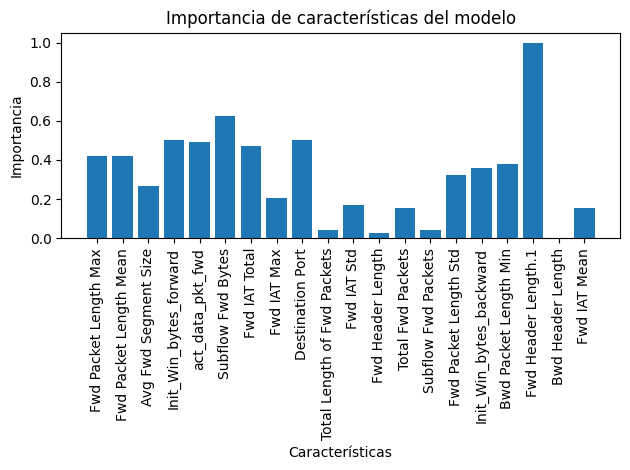

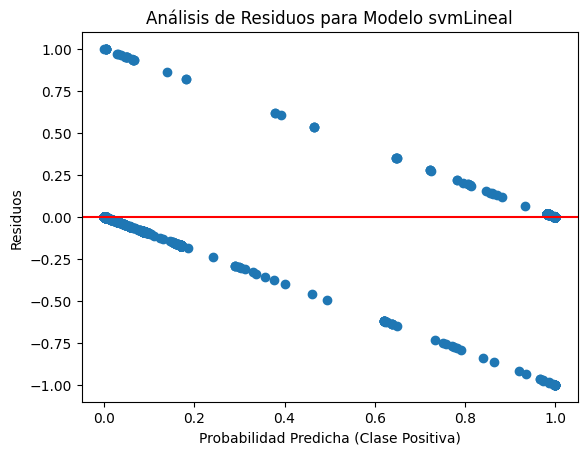

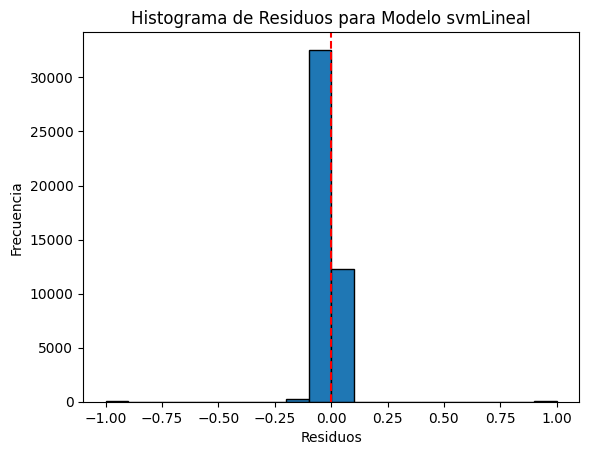

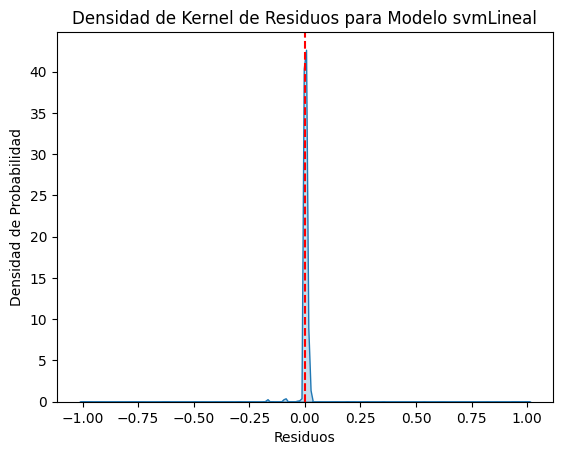

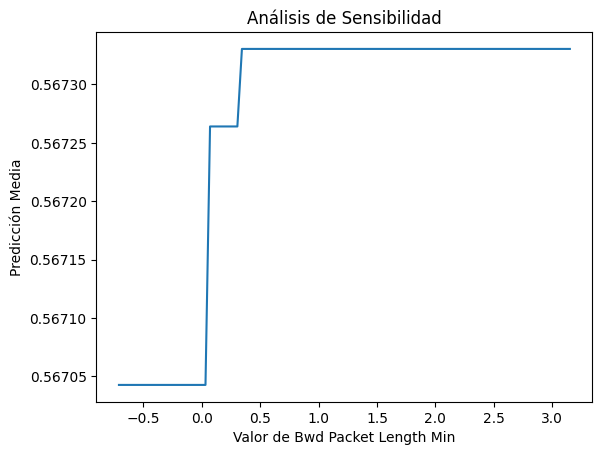

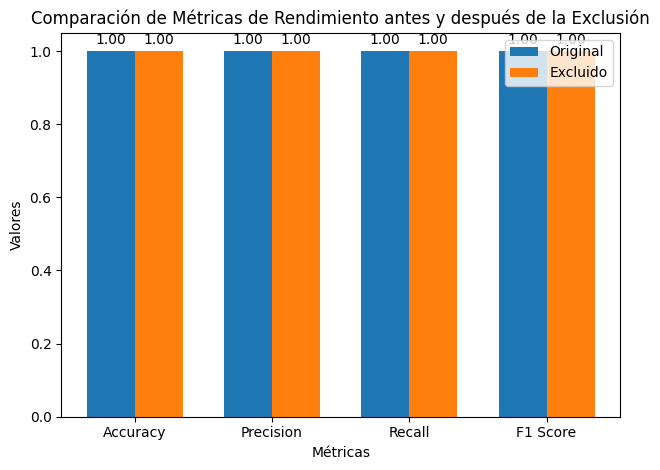

Precisión original: 0.9998006335422989
Precisión después de la permutación de la característica: 0.9997784817136655
Cambio en la precisión: -2.215182863340992e-05


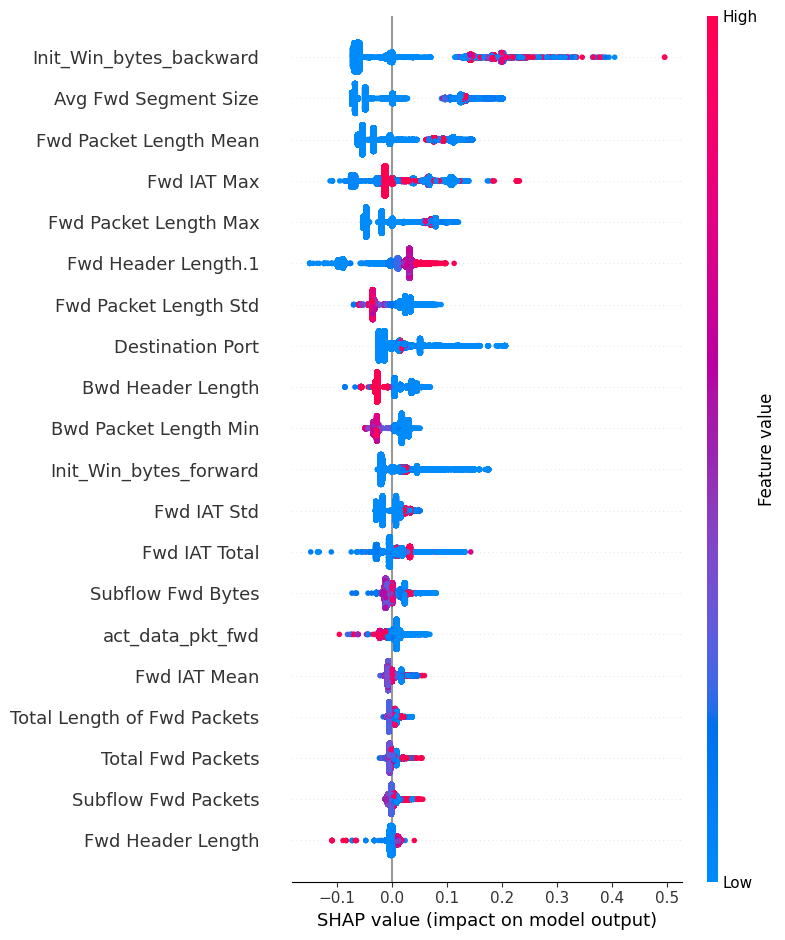

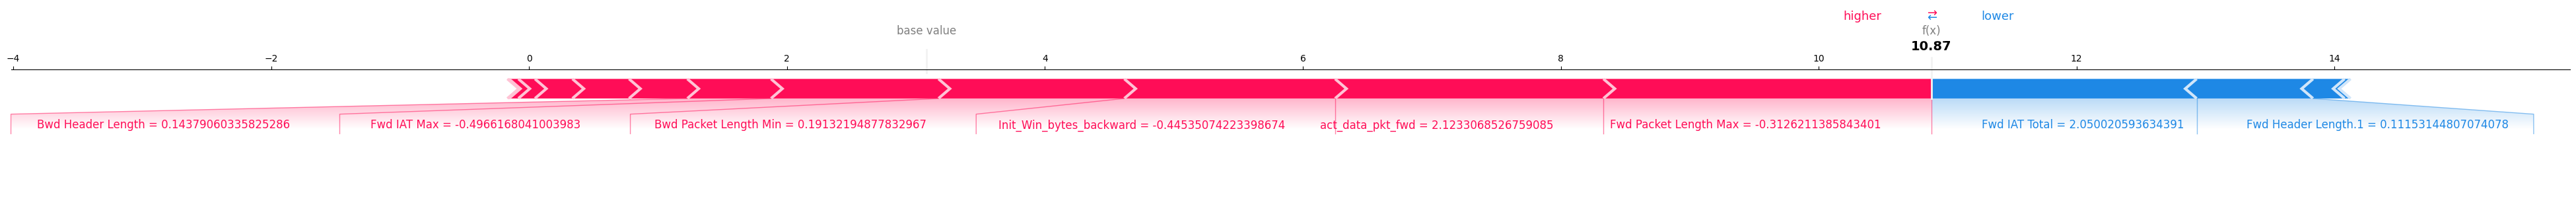

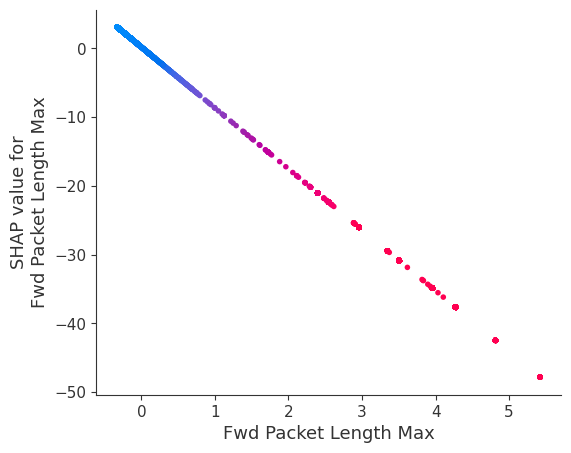

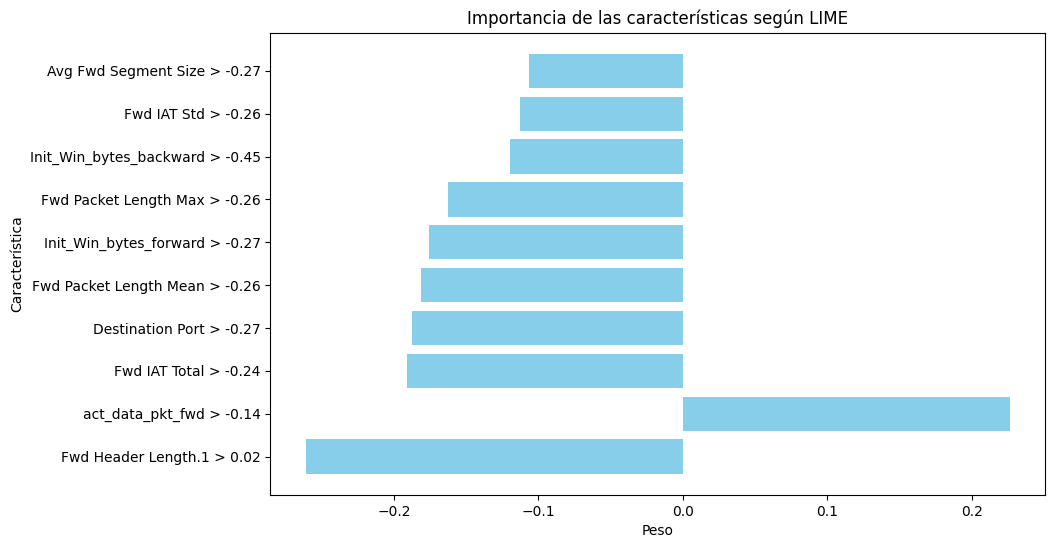

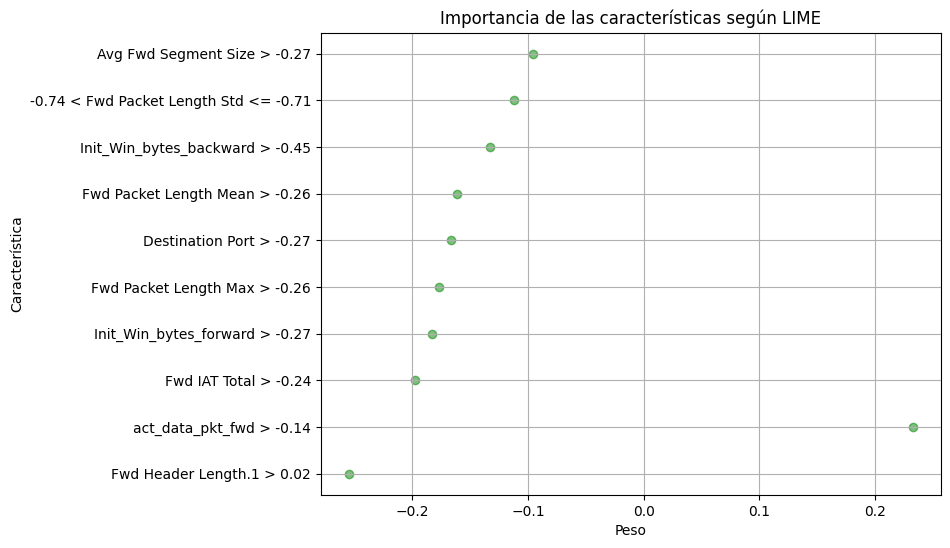

In [19]:
# Celda para ejecutar las distintas funciones, ya hay ejemplos de las últimas ejecuciones, si no en cada celda
# de cada función hay un ejemplo para cada modelo, basta con copiar y pegar aquí y si se quiere cambiar algún
# parametro como la característica, instancia etc.

explicabilidad_global(logisticRegression_model_DDOS, top_20_feature_names) 
analisis_residuos('svmLineal', X_test, y_test)
analisis_sensibilidad(xgBoost_model_DDOS, X_test, 16) 
analisis_influencia(xgBoost_model_DDOS,'xgBoost', X_test_df, y_test_encoded, slice(18000, 35500)) 
permutacion_de_caracteristicas(randomForest_modelDDOS, X_test, y_test, 0) 
shap_valores_globales(randomForest_modelDDOS, 'randomForest', top_20_feature_names)
shap_explicacion_local('xgBoost', X_test, 1, top_20_feature_names) 
shap_valores_vs_reales('svmLineal', X_test_df, top_20_feature_names, 0) 
lime_analisis_instancias('svmLineal', X_train, X_test, sample_index=0, feature_names=top_20_feature_names) 
lime_analisis_caracteristicas('logisticRegression', X_train, X_test, sample_index=2, feature_names=top_20_feature_names) 
lime_analisis_caracteristicasDispersion('logisticRegression', X_train, X_test, sample_index=2, feature_names=top_20_feature_names) 